# **Spotify Sentiment Analysis**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This notebook contains **Sentiment Analysis on Spotify User Reviews**. My interest in Natural Language Processing motivated this project, showcasing how sentiment analysis provides valuable insights for business growth and customer satisfaction.

# **Libraries**

**Data Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

**NLP Text Libraries**

In [3]:
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


**Exploratory Data Analysis(EDA) Analysis**

In [4]:
# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

**Feature Engineering**

In [5]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

**Model Selection and Evaluation**

In [6]:
# Model Building
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

In [7]:
# Suppress Convergence and FitFailed warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning, module="sklearn")

# **The Dataset**

The dataset that we will use is taken from Kaggle website and can be downloaded here:

[**Spotify App Reviews**
](https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022?resource=download)

The dataset is available in CSV format, which we will use in this project.

Overall, the dataset talks about the feedback received from customers who used the Spotify app.



**Read The Dataset**

In [8]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reviews.csv")

**Shape of The Dataset**

In [9]:
dataset.shape

(61594, 5)

In [10]:
dataset.columns

Index(['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply'], dtype='object')

# **Data Preprocessing**

**Checking Null Values**

In [11]:
dataset.isnull().sum()

,0
Time_submitted,0
Review,0
Rating,0
Total_thumbsup,0
Reply,61378


**Filling Missing Values**

In [12]:
dataset.Review.fillna(value = "", inplace = True)

<ipython-input-12-b5e25bff94ad>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset.Review.fillna(value = "", inplace = True)


**Concatenate `reviewText` and `summary` Columns**

In [13]:
dataset["reviews"] = dataset["Review"] + " " + dataset["Reply"].fillna("")
dataset.drop(columns=["Review", "Reply"], axis=1, inplace=True)

**Statistic Description of The Dataset**

In [14]:
dataset.describe(include = "all")

,Time_submitted,Rating,Total_thumbsup,reviews
count,61594,61594.000000,61594.000000,61594
unique,61300,NaN,NaN,61356
top,2022-03-08 18:49:19,NaN,NaN,Too many ads
freq,4,NaN,NaN,36
mean,NaN,3.155989,7.649381,NaN
std,NaN,1.673285,89.323143,NaN
min,NaN,1.000000,0.000000,NaN
25%,NaN,1.000000,0.000000,NaN
50%,NaN,3.000000,0.000000,NaN
75%,NaN,5.000000,1.000000,NaN


**Percentages of Ratings Given from The Customers**

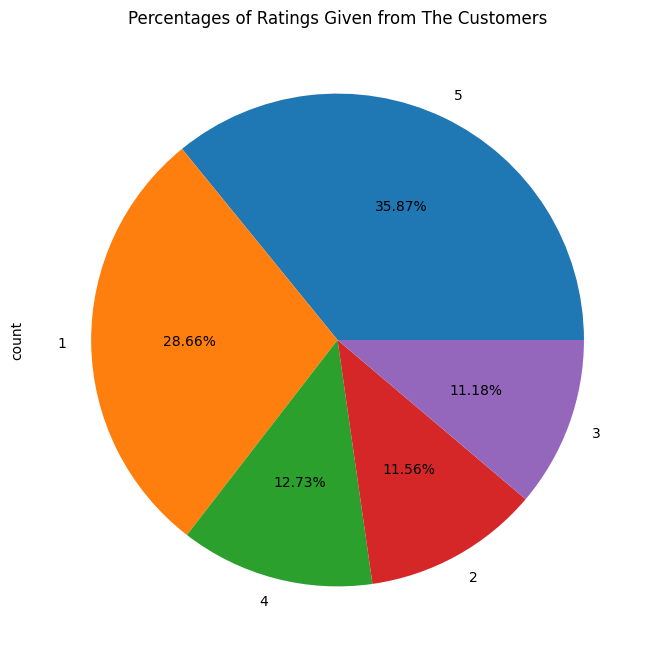

In [15]:
dataset['Rating'].value_counts().plot(kind='pie', legend=False, autopct='%1.2f%%', fontsize=10, figsize=(8, 8))
plt.title("Percentages of Ratings Given from The Customers", loc="center")
plt.show()

From the chart above, we can see the distribution of ratings for the Spotify app reviews. The majority of the reviews have a rating of 5, accounting for 35.87% of the dataset. Following that, 4-star ratings make up 12.73%, while 3-star ratings contribute 11.81%. The 2-star and 1-star ratings are relatively close, with 2-star reviews at 11.56% and 1-star reviews at 28.66%.

**Labelling Products Based On Ratings Given**

Our dataset does not contain a dependent variable, meaning there is no direct prediction target available. To address this, we will categorize each sentiment based on the ratings provided in the dataset. Reviews with ratings greater than 3.0 will be labeled as **Positive** since they indicate satisfaction with the product. Reviews with a rating of exactly 3.0 will be classified as **Neutral**, reflecting an indifferent or balanced sentiment. Lastly, reviews with ratings below 3.0 will be labeled as **Negative**, indicating dissatisfaction. This categorization will help us create a prediction target for sentiment analysis and classification in our model.

In [16]:
def Labelling(Rows):
    if Rows["Rating"] > 3.0:
        Label = "Positive"
    elif Rows["Rating"] < 3.0:
        Label = "Negative"
    else:
        Label = "Neutral"
    return Label

In [17]:
dataset["sentiment"] = dataset.apply(Labelling, axis=1)

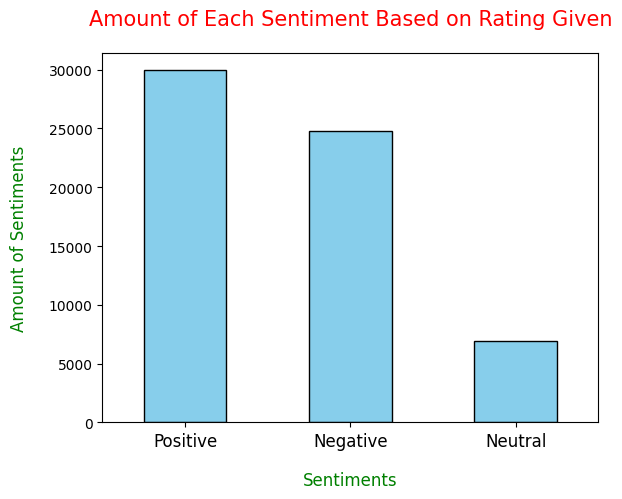

In [18]:
# Plot the sentiment distribution as a bar chart
dataset["sentiment"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")

# Customize the title and labels
plt.title("Amount of Each Sentiment Based on Rating Given", loc="center", fontsize=15, color="red", pad=20)
plt.xlabel("Sentiments", color="green", fontsize=12, labelpad=15)
plt.xticks(rotation=0, fontsize=12)
plt.ylabel("Amount of Sentiments", color="green", fontsize=12, labelpad=15)

# Display the plot
plt.show()


In this part we can actually change the labels into numeric values but for the sake of experiments we will do it later. Also, notice that from the graph we can know that most of our data contains positive sentiments, which is true from the exploration before.

# **Text Processing**

**Text Cleaning**

In [19]:
def Text_Cleaning(Text):
    # Lowercase the text
    Text = Text.lower()

    # Clean punctuations in the text (remove them)
    punc = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    Text = Text.translate(punc)

    # Remove numbers in the text
    Text = re.sub(r'\d+', '', Text)

    # Remove possible links (URLs)
    Text = re.sub(r'https?://\S+|www\.\S+', '', Text)

    # Remove newlines and carriage returns
    Text = re.sub(r'[\n\r]', ' ', Text)

    # Optional: Remove extra spaces (if there are any after cleaning)
    Text = re.sub(r'\s+', ' ', Text).strip()

    return Text


**Text Processing**

In [20]:
# Stopwords, preserving 'not' for sentiment negation
Stopwords = set(nltk.corpus.stopwords.words("english"))

def Text_Processing(Text):
    if not Text:  # Check if Text is empty or None
        return ''

    # Initialize lemmatizer
    Lemmatizer = WordNetLemmatizer()

    # Tokenize the text
    Tokens = nltk.word_tokenize(Text)

    # Remove stopwords, preserve 'not', and lemmatize
    Processed_Text = [
        Lemmatizer.lemmatize(word.lower()) for word in Tokens
        if (word.lower() not in Stopwords or word.lower() == "not") and word.isalpha()  # Keep 'not'
    ]

    # Return processed text as a string
    return " ".join(Processed_Text)


**Applying the Functions**

In [21]:
# Apply Text Cleaning and Text Processing in sequence
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Cleaning(Text))
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Processing(Text))

# **Exploratory Data Analysis**

**Overview of The Dataset**

In [22]:
dataset.head(n = 10)

,Time_submitted,Rating,Total_thumbsup,reviews,sentiment
0,2022-07-09 15:00:00,5,2,great music service audio high quality app eas...,Positive
1,2022-07-09 14:21:22,5,1,please ignore previous negative rating app sup...,Positive
2,2022-07-09 13:27:32,4,0,pop get best spotify experience android annoyi...,Positive
3,2022-07-09 13:26:45,1,1,really buggy terrible use recently,Negative
4,2022-07-09 13:20:49,1,1,dear spotify get song put playlist shuffle play,Negative
5,2022-07-09 13:20:20,3,7,player control sometimes disappear reason app ...,Neutral
6,2022-07-09 13:19:21,5,0,love selection lyric provided song listening,Positive
7,2022-07-09 13:17:22,3,16,still extremely slow changing storage external...,Neutral
8,2022-07-09 13:16:49,5,0,great app best mp music app ever used one prob...,Positive
9,2022-07-09 13:11:32,1,318,deleting app following reason app failing busi...,Negative


*With the overview above, we know that for sentiment analysis that we will do, `reviews` is important to our model and we should use this aspect as our feature. By using this feature, we will need to predict what our sentiment will be classified into.*

**About Other Features**

In [23]:
dataset.describe(include = "all")

,Time_submitted,Rating,Total_thumbsup,reviews,sentiment
count,61594,61594.000000,61594.000000,61594,61594
unique,61300,NaN,NaN,60739,3
top,2022-03-08 18:49:19,NaN,NaN,many ad,Positive
freq,4,NaN,NaN,65,29937
mean,NaN,3.155989,7.649381,NaN,NaN
std,NaN,1.673285,89.323143,NaN,NaN
min,NaN,1.000000,0.000000,NaN,NaN
25%,NaN,1.000000,0.000000,NaN,NaN
50%,NaN,3.000000,0.000000,NaN,NaN
75%,NaN,5.000000,1.000000,NaN,NaN


*Now, we will revisit the statistical description of our dataset. The **Time_submitted** and **Reply** columns are unlikely to impact sentiment analysis and may be excluded. While **Total_thumbsup** could provide some insights, its direct relation to sentiment is unclear, so it may also be excluded. We will focus primarily on the **Review** and **Rating** columns for sentiment analysis.*

**Polarity, Review Length, and Word Counts**

*To justify our analysis before, we will dive further into the dataset a bit more from the polarity of the texts, also from the words used in the reviews. We will generate some new columns in our dataset and visualize it.*

#**Polarity**

In [24]:
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

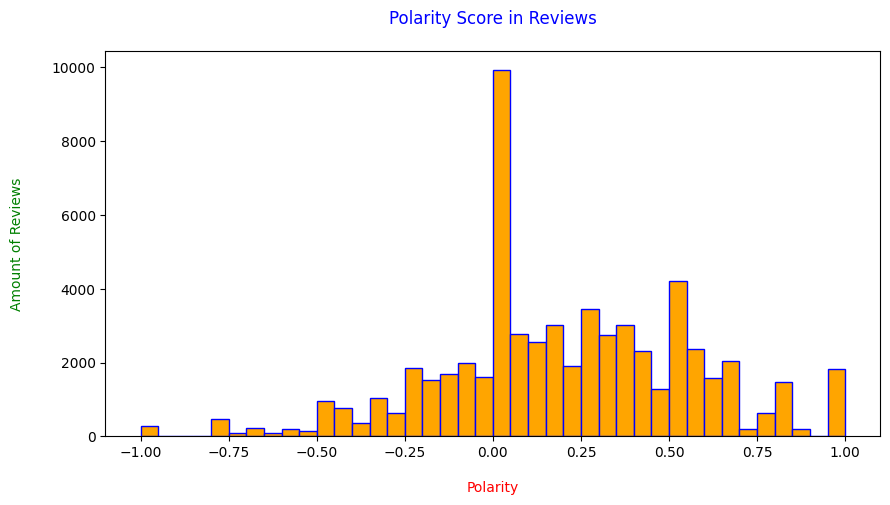

In [25]:
dataset["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in Reviews", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

Reviews with negative polarity will be in range of [-1, 0), neutral ones will be 0.0, and positive reviews will have the range of (0, 1].

*From the histogram above, we know that most of the reviews are distributed in positive sentiments, meaning that what we extracted from our analysis before is true. Statistically, this histogram shows that our data is normally distributed, but not with standard distribution. In conclusion, we know for sure that our analysis about the amount of sentiments from the reviews is correct and corresponds to the histogram above.*

**Review Length**

In [26]:
dataset["length"] = dataset["reviews"].astype(str).apply(len)

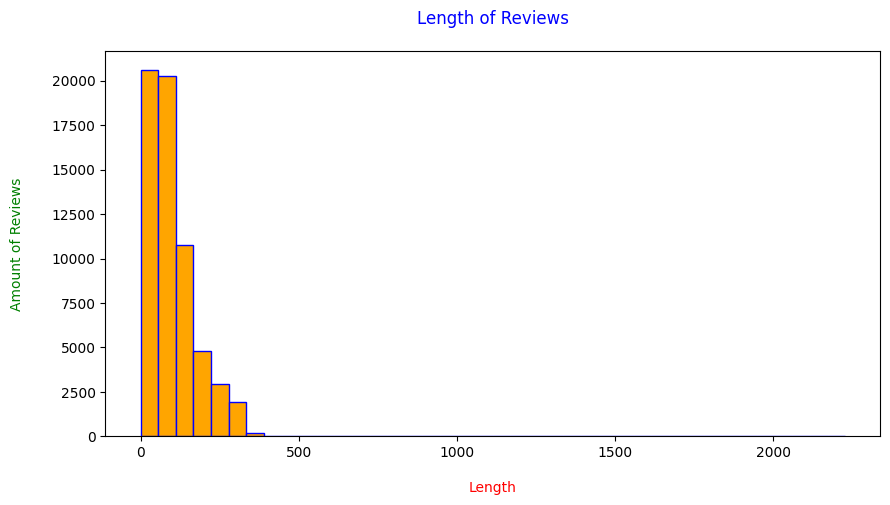

In [27]:
dataset["length"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Length of Reviews", color = "blue", pad = 20)
plt.xlabel("Length", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

*Based on this, we know that our review has text length between approximately 0-500 characters. The distribution itself has positive skewness, or in other words it is skewed right, and this means that our reviews rarely has larger length than 500 characters. Of course, the review that we use here is affected by the text preprocessing phase, so the length might not be the actual value of the review itself as some words might have been omitted already. This will also have the same effect when we count the tatal of words in our reviews.*

**Word Counts**

In [28]:
dataset["word_counts"] = dataset["reviews"].apply(lambda x: len(str(x).split()))

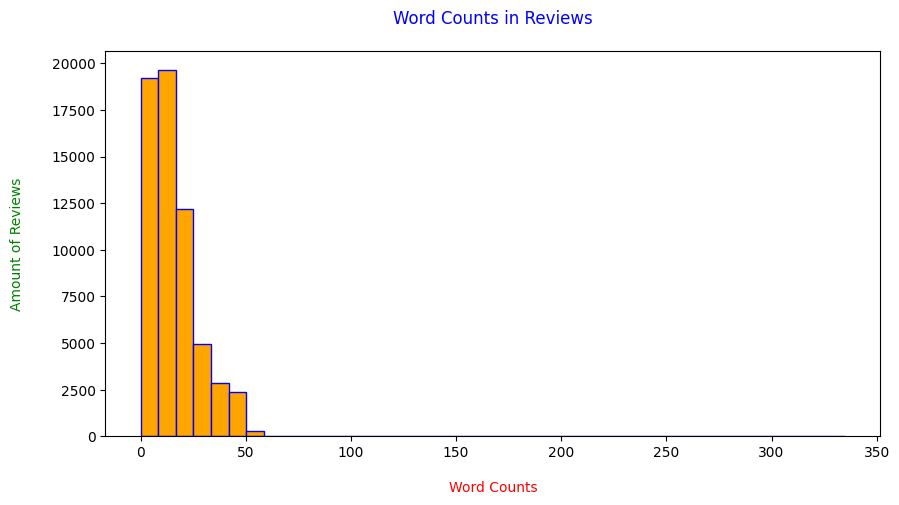

In [29]:
dataset["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Word Counts in Reviews", color = "blue", pad = 20)
plt.xlabel("Word Counts", labelpad = 15, color = "red")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "green")

plt.show()

*From the figure above, we infer that most of the reviews consist of 0-50 words. Just like before, the distribution is skewed right and the calculation is affected by our text preprocessing phase before.*

# **N-Gram Analysis**

**N-Gram Function**

In [30]:
def Gram_Analysis(Corpus, Gram, N):
    # Vectorizer
    Vectorizer = CountVectorizer(stop_words=Stopwords, ngram_range=(Gram, Gram))

    # N-Grams Matrix
    ngrams = Vectorizer.fit_transform(Corpus)

    # N-Grams Frequency
    Count = ngrams.sum(axis=0)

    # List of Words
    words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

    # Sort Descending With Key = Count
    words = sorted(words, key=lambda x: x[1], reverse=True)

    # Optional: Return top N most frequent n-grams as a list of tuples (word, frequency)
    return words[:N]


**Filter The DataFrame Based On Sentiments**

In [31]:
# Use dropna() so the base DataFrame is not affected
Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()

**Unigram of Reviews Based on Sentimeitalicized textnts**

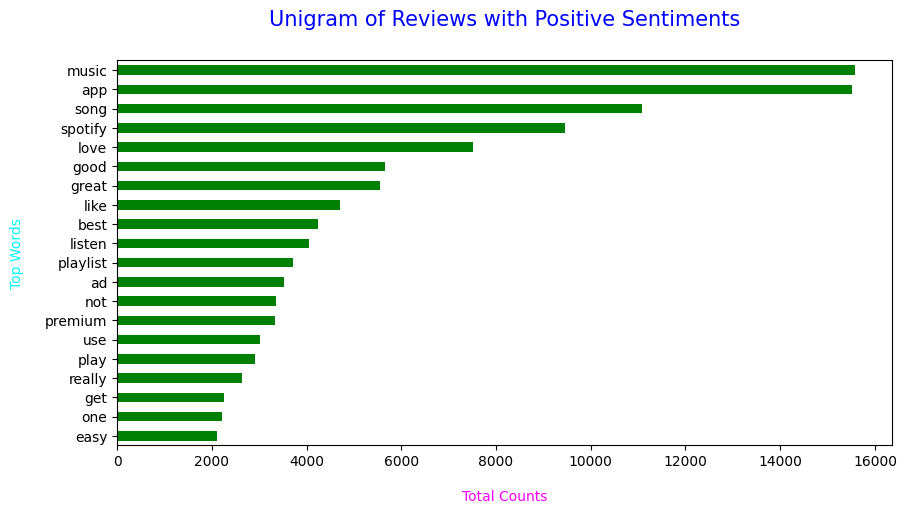

In [32]:
# Assuming 'Stopwords' is a list of stop words that you want to use.
Stopwords = [...]  # Replace with your custom list of stop words

# Finding Unigram
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()


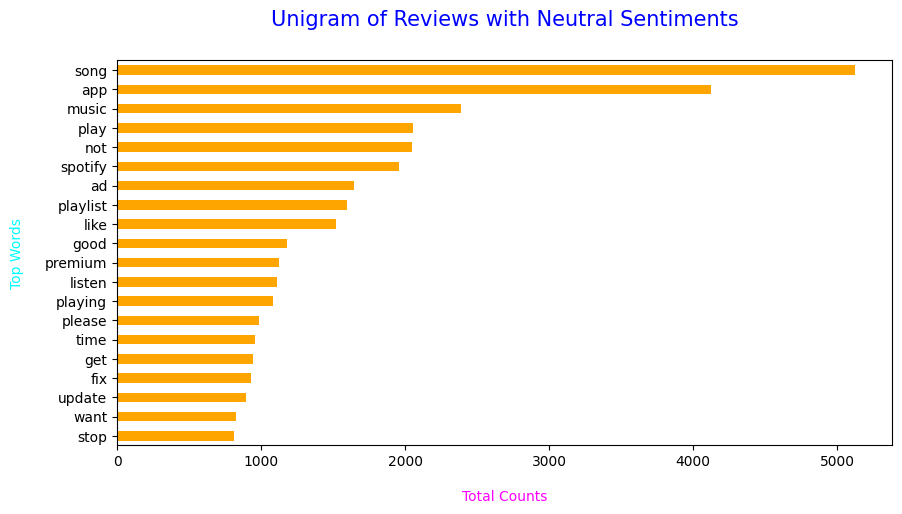

In [33]:
# Finding Unigram for Neutral Sentiment
words = Gram_Analysis(Neutral["reviews"].dropna(), 1, 20)  # Drop any NaN values in the reviews column
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()


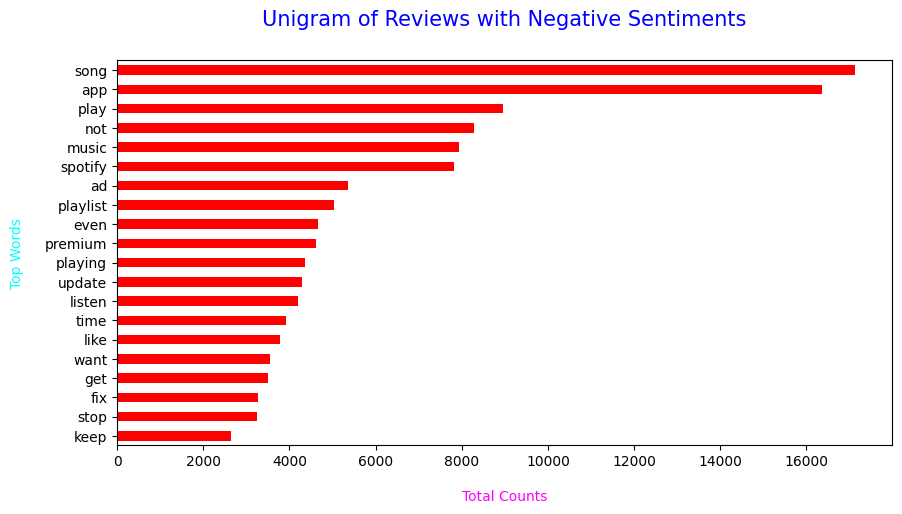

In [34]:
# Finding Unigram for Negative Sentiment
words = Gram_Analysis(Negative["reviews"].dropna(), 1, 20)  # Drop NaN values
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()


**Bigram of Reviews Based on Sentiments**

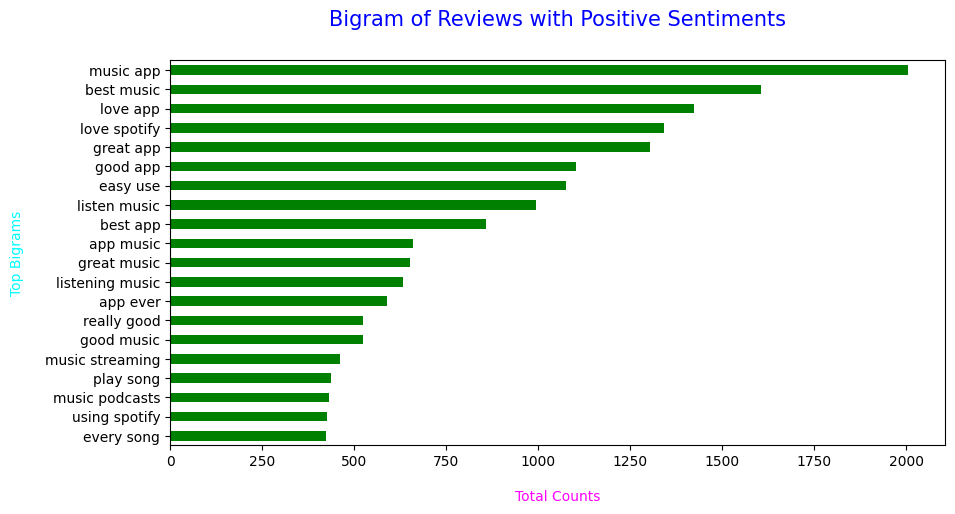

In [35]:
# Finding Bigram for Positive Sentiment
words = Gram_Analysis(Positive["reviews"].dropna(), 2, 20)  # Drop NaN values to avoid issues
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Bigrams", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()


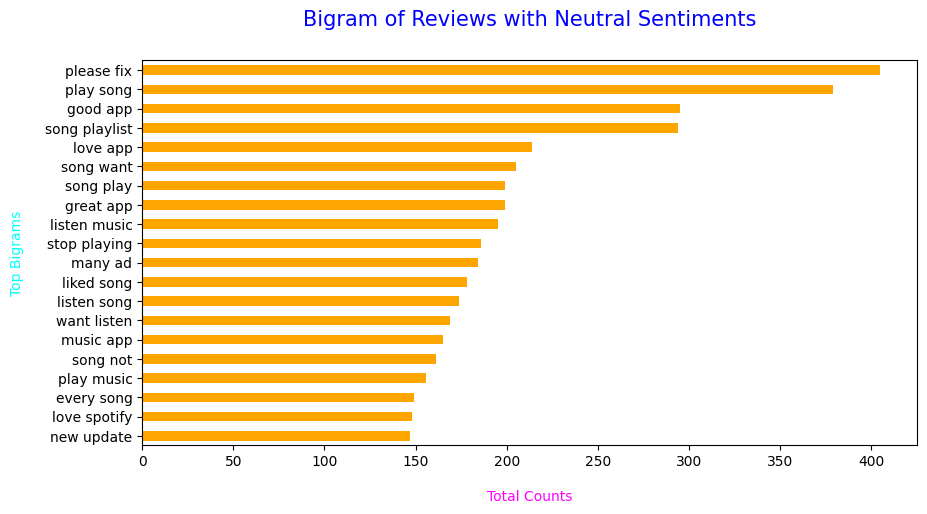

In [36]:
# Finding Bigram for Neutral Sentiment
words = Gram_Analysis(Neutral["reviews"].dropna(), 2, 20)  # Drop NaN values to avoid issues
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Bigrams", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()


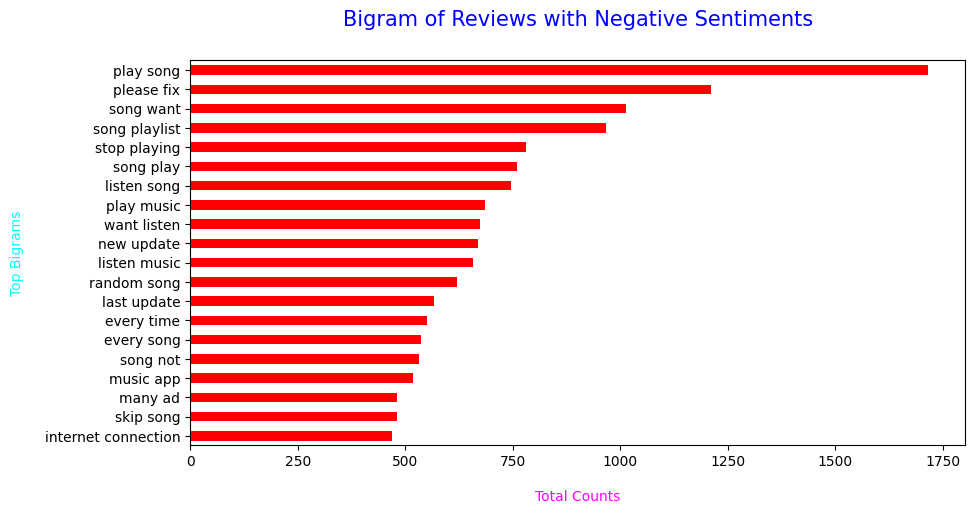

In [37]:
# Finding Bigram for Negative Sentiment
words = Gram_Analysis(Negative["reviews"].dropna(), 2, 20)  # Drop NaN values to avoid issues
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Bigrams", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()


*The bigrams work better than the unigrams as they capture phrases that clearly reflect the sentiment. For negative sentiment (play song), phrases reveal user frustrations with song selection, while for neutral sentiment (please fix), they suggest a balanced, non-biased view. In positive sentiment (music app), bigrams highlight phrases that indicate users are enjoying the music selection, reinforcing the app’s success.*

**Trigram of Reviews Based on Sentiments**

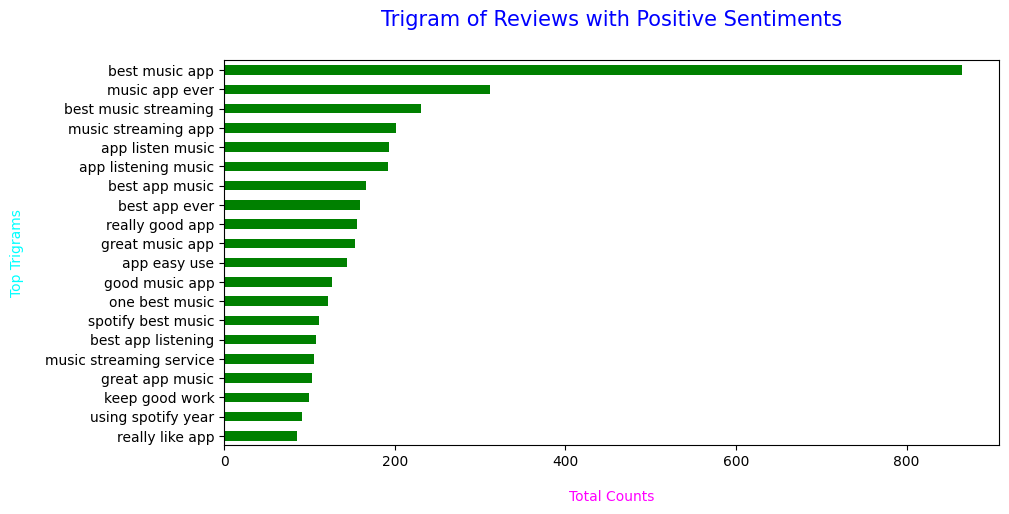

In [38]:
# Finding Trigram for Positive Sentiment
words = Gram_Analysis(Positive["reviews"].dropna(), 3, 20)  # Drop NaN values to avoid issues
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Trigrams", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

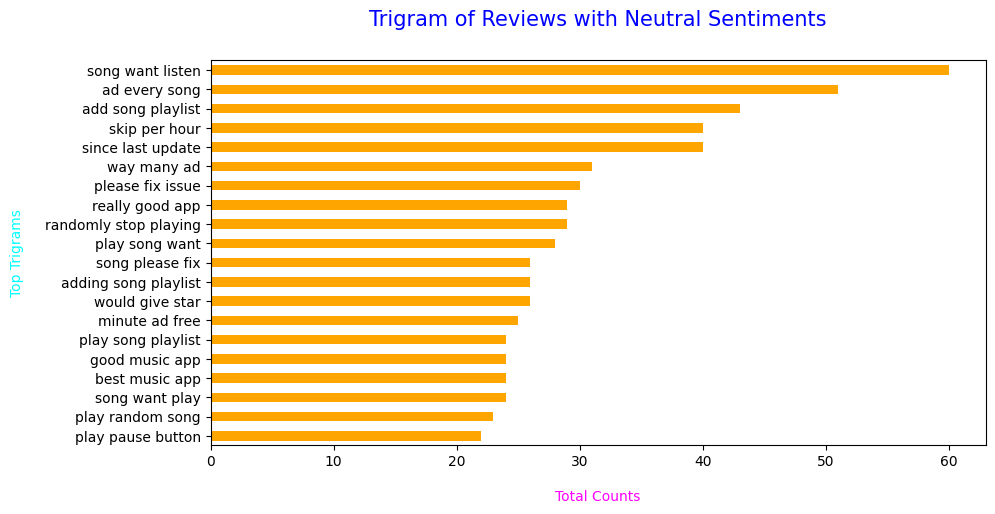

In [39]:
# Finding Trigram for Neutral Sentiment
words = Gram_Analysis(Neutral["reviews"].dropna(), 3, 20)  # Drop NaN values to avoid issues
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Trigrams", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

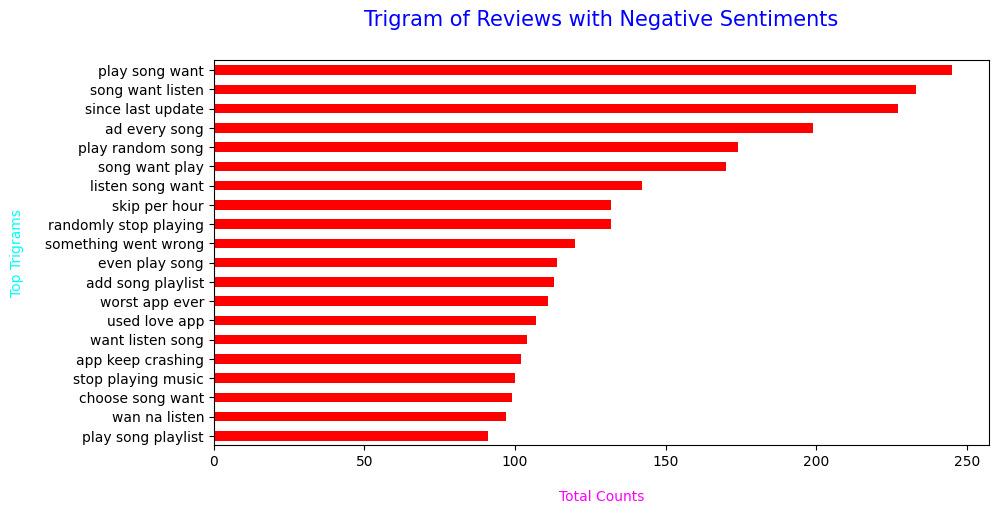

In [40]:
# Finding Trigram for Negative Sentiment
words = Gram_Analysis(Negative["reviews"].dropna(), 3, 20)  # Drop NaN values to avoid issues
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Trigrams", color = "cyan", fontsize = 10, labelpad = 15)
plt.show()

*Trigrams perform better in capturing sentiment, with negative ones highlighting issues with song choices, neutral ones focusing on fixes, and positive ones reflecting satisfaction with the app. Not removing 'not' from stopwords preserves negation, influencing the sentiment interpretation, especially in negative feedback.*

# **Word Clouds**

**Word Cloud of Reviews with Positive Sentiments**

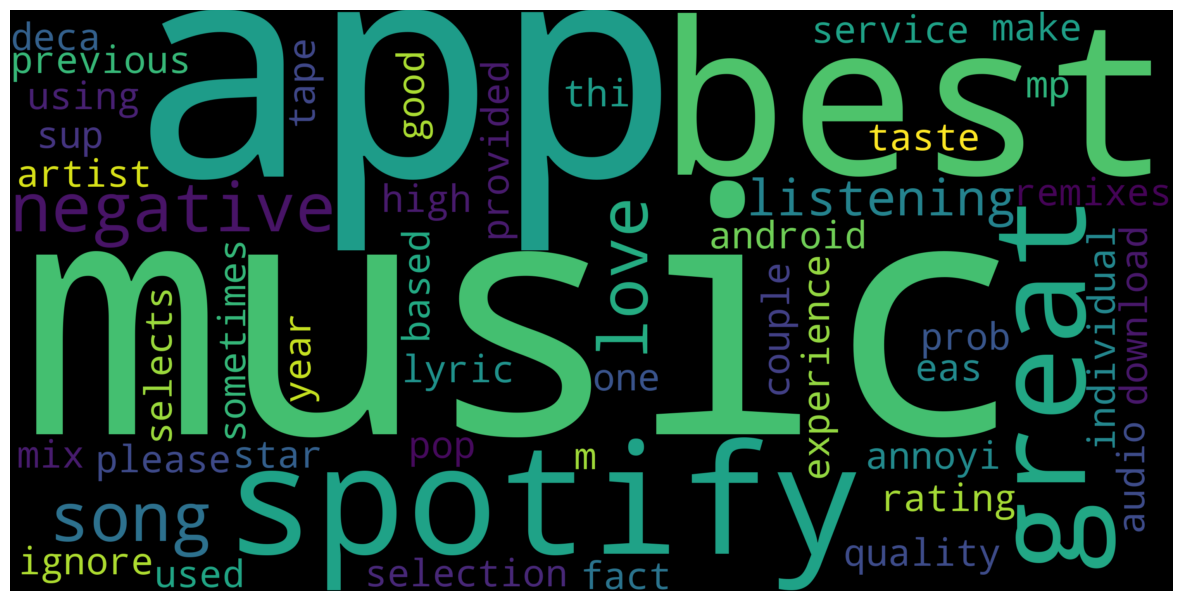

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
Stopwords = STOPWORDS
# Generate WordCloud for Positive sentiment reviews
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["reviews"].dropna()))

# Visualization
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()


**Word Cloud of Reviews with Neutral Sentiments**

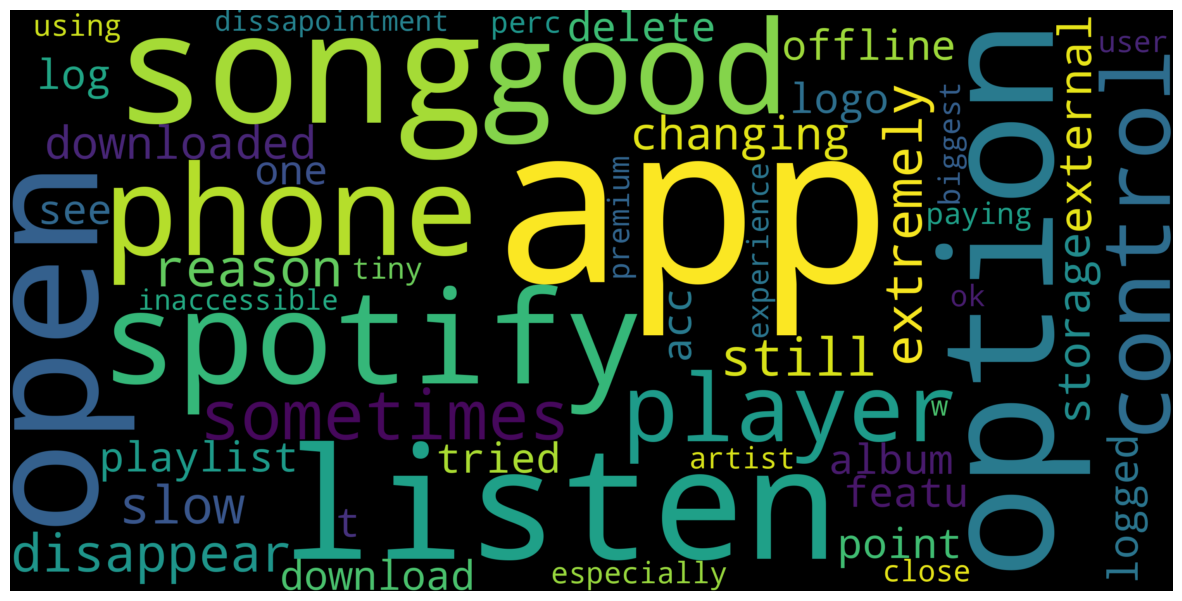

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
Stopwords = STOPWORDS
# Ensure the 'Neutral["reviews"]' column contains text data and handle NaN values if necessary
wordCloud = WordCloud(max_words=50, width=3000, height=1500, stopwords=Stopwords).generate(str(Neutral["reviews"].dropna()))

# Visualization
plt.figure(figsize=(15, 15))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()


**Word Cloud of Reviews with Negative Sentiments**

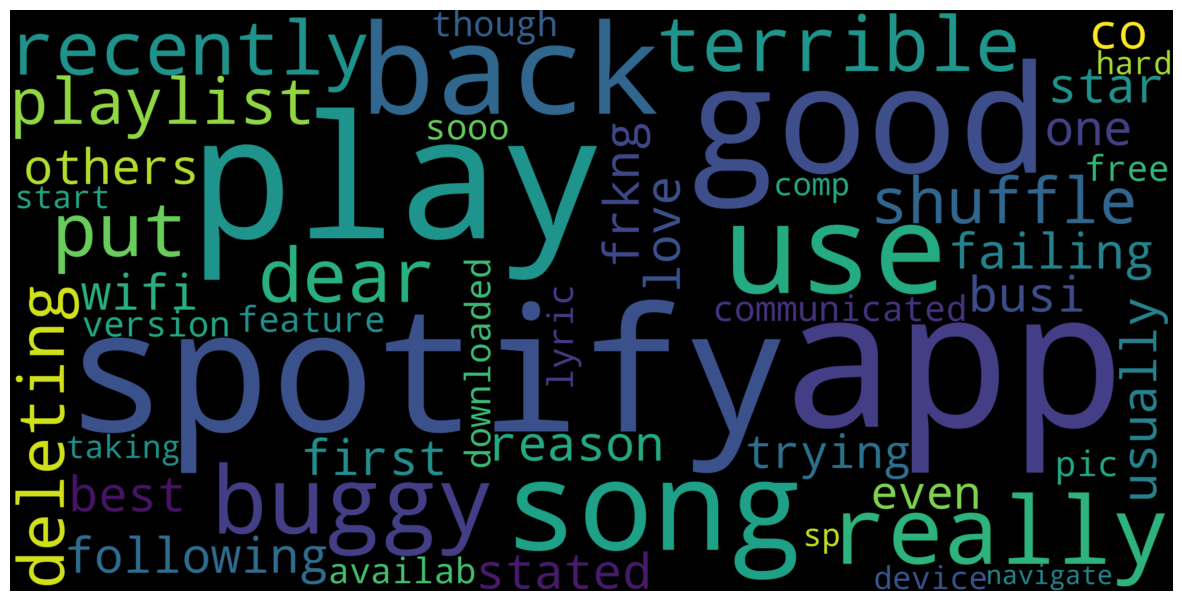

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
Stopwords = STOPWORDS
# Ensure the 'Negative["reviews"]' column contains text data and handle NaN values if necessary
wordCloud = WordCloud(max_words=50, width=3000, height=1500, stopwords=Stopwords).generate(str(Negative["reviews"].dropna()))

# Visualization
plt.figure(figsize=(15, 15))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()


*From these word clouds, not only we can see words that really describe our sentiments, but just like our N-Grams Analysis we can see objects being discussed in the reviews given.*

#**Feature Engineering**

**Drop Insignificant Columns**

In [44]:
# Check the columns in the dataset
print("Columns before dropping:", dataset.columns)

# Specify the columns to drop
Columns_to_drop = ['Time_submitted', 'Rating', 'Total_thumbsup']

# Drop the specified columns if they exist
dataset.drop(columns=[col for col in Columns_to_drop if col in dataset.columns], axis=1, inplace=True, errors='ignore')

# Verify the columns after dropping
print("Columns after dropping:", dataset.columns)


Columns before dropping: Index(['Time_submitted', 'Rating', 'Total_thumbsup', 'reviews', 'sentiment',
       'polarity', 'length', 'word_counts'],
      dtype='object')
Columns after dropping: Index(['reviews', 'sentiment', 'polarity', 'length', 'word_counts'], dtype='object')


*We dropped unnecessary columns to simplify the dataset, keeping only the essential independent and dependent variables. The next step is encoding the labels into numerical values corresponding to their categories.*

**Current State of The Dataset**

In [45]:
dataset.head()

,reviews,sentiment,polarity,length,word_counts
0,great music service audio high quality app eas...,Positive,0.420333,79,13
1,please ignore previous negative rating app sup...,Positive,0.166667,69,11
2,pop get best spotify experience android annoyi...,Positive,0.100000,67,11
3,really buggy terrible use recently,Negative,-0.266667,34,5
4,dear spotify get song put playlist shuffle play,Negative,0.000000,47,8


**Encoding Our Target Value**

In [46]:
# Initialize the LabelEncoder
Encoder = LabelEncoder()
# Encode the 'sentiment' column in the dataset
dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])

In [47]:
# Check the distribution of the 'sentiment' column after encoding
print(dataset["sentiment"].value_counts())

sentiment
2    29937
0    24771
1     6886
Name: count, dtype: int64


*We have successfully encoded the sentiment labels into numerical values: Positive as 2, Neutral as 1, and Negative as 0. The next step is to assign weights to each word in the review using the TF-IDF (Term Frequency - Inverse Document Frequency) Vectorizer.*

**TF-IDF Vectorizer**

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import STOPWORDS

# Convert Stopwords to a list if it's a set
Stopwords = list(STOPWORDS)

# Defining the vectorizer with bigrams and custom stop words
TF_IDF = TfidfVectorizer(max_features=5000, ngram_range=(2, 2), stop_words='english')
# Fitting and transforming the reviews into a matrix of weighted words
X = TF_IDF.fit_transform(dataset["reviews"].dropna())

# Check the shape of the resulting matrix
print(X.shape)


(61594, 5000)


In [49]:
# Declaring our target variable
y = dataset["sentiment"]

*From the shape, we successfully transformed our reviews using the TF-IDF Vectorizer, extracting the top 5000 bigram words. As we know, our dataset is imbalanced, with significantly fewer neutral and negative sentiments compared to positive ones. Therefore, we need to balance the dataset before proceeding with the modeling process.*

**Resampling Our Dataset**

*There are many ways to do resampling to an imbalanced dataset, such as SMOTE and Bootstrap Method. We will use SMOTE (Synthetic Minority Oversampling Technique) that will randomly generate new replicates of our undersampling data to balance our dataset.*

In [50]:
Counter(y)

Counter({2: 29937, 0: 24771, 1: 6886})

In [51]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [52]:
Counter(y_final)

Counter({2: 29937, 0: 29937, 1: 29937})

*Now our data is already balanced as we can see from the counter of each sentiment categories before and after the resampling with SMOTE.*

**Spliting Our Dataset**

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

**Scale the Features**

In [54]:
# Initialize the scaler with with_mean=False for sparse matrices
scaler = StandardScaler(with_mean=False)
# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data
X_test_scaled = scaler.transform(X_test)

In [55]:
# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

*We split our dataset into a 75:25 ratio for the training and test sets, respectively.*

# **Model Selection and Evaluation**

*We do not really know what is the best model that fits our data well. Because of that, we will need to try every classification models available and find the best models using the Confusion Matrix and F1 Score as our main metrics, and the rest of the metrics as our support. First, we should do some cross validation techniques in order to find the best model.*

**Model Building**

*We are using K-Fold Cross Validation on our initial dataset (before resampling), as the CV method itself is not influenced by the imbalanced data. By applying CV on the balanced dataset post-resampling, we expect to achieve similar results.*

In [ ]:
# Models
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC_model = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC_model, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

# Cross-validation and accuracy evaluation
for i, model in enumerate(Models):
    accuracy = cross_val_score(model, X_final, y_final, cv = 10, scoring = "accuracy").mean()
    print("{} Test Accuracy: {}".format(Models_Dict[i], accuracy))

Decision Tree Test Accuracy: 0.7023201037168175
Logistic Regression Test Accuracy: 0.6809976867714322


In [56]:
# Customized Code: Decision Tree and Logistic Regression only
# Initialize the models
decision_tree = DecisionTreeClassifier()
logistic_regression = LogisticRegression()

# Cross-validation for Decision Tree
dt_accuracy = cross_val_score(decision_tree, X_final, y_final, cv=10, scoring="accuracy").mean()
print("Decision Tree Test Accuracy: {:.4f}".format(dt_accuracy))

# Cross-validation for Logistic Regression
lr_accuracy = cross_val_score(logistic_regression, X_final, y_final, cv=10, scoring="accuracy").mean()
print("Logistic Regression Test Accuracy: {:.4f}".format(lr_accuracy))

Decision Tree Test Accuracy: 0.7016
Logistic Regression Test Accuracy: 0.6810


*We have six models at our disposal, and from the results of the 10-Fold Cross Validation, we see that the Logistic Regression model performs the best, achieving the highest accuracy, slightly outperforming the SVC. Based on these results, we will proceed with Logistic Regression as our model of choice to predict sentiment. Additionally, we will fine-tune the model’s parameters and evaluate the end results to assess its performance further.*

**Hyperparameter Tunning**

In [57]:
# Hyperparameter tuning for Logistic Regression
param_grid = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                           param_grid=param_grid,
                           scoring="accuracy",
                           cv=10,
                           verbose=0,
                           n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Best accuracy and parameters
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

# Print the best accuracy and parameters
print("Best Accuracy: {:.2f} %".format(best_accuracy * 100))
print("Best Parameters:", best_parameters)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan 0.6816265         nan 0.68128503        nan 0.68131471
        nan 0.6810772         nan 0.68052788        nan 0.67978556
        nan 0.67914715        nan 0.67890962        nan 0.67844941
        nan 0.67825645        nan 0.67803375        nan 0.67776651
        nan 0.67758834        nan 0.67735081        nan 0.67739534
        nan 0.67686088        nan 0.6768015         nan 0.67690542
        nan 0.67668273        nan 0.67637096        nan 0.67666788
        nan 0.67675696        nan 0.6767718         nan 0.67674211
        nan 0.67675696        nan 0.67678666        nan 0.67672727
        nan 0.67669758        nan 0.67687574        nan 0.67692027
        nan 0.67681636        nan 0.67678666        nan 0.67672728
        nan 0.67677182        nan 0.67678666        nan 0.6768312
        nan 0.67669759        nan 0.67669759        nan 

Best Accuracy: 68.16 %
Best Parameters: {'C': 0.0001, 'penalty': 'l2'}


*We got a nice accuracy on our training set, which is 68.16% and from our Grid Search, we are also able to find our optimal hyperparameters. It is time to finish our model using these parameters to get the best model of Logistic Regression.*

**Best Model**

In [58]:
# Fit the Logistic Regression classifier with the best parameters
Classifier = LogisticRegression(random_state=42, C=6866.488450042998, penalty='l2')

# Fit the model on the scaled training data
Classifier.fit(X_train_scaled, y_train)

# Predict using the fitted model on the scaled test data
Prediction = Classifier.predict(X_test_scaled)

# Calculate and print the accuracy of the predictions
accuracy = accuracy_score(y_test, Prediction)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Test Accuracy: 67.72%


*Now that our model is done, we will test our model on our test set. The metrics that we will evaluate is based on this prediction that we made here.*

**Metrics**

Accuracy on The Test

In [59]:
accuracy_score(y_test, Prediction)

0.6771923573687257

*Really high accuracy that we got here, 67.71%. Still, we need to look out for the Confusion Matrix and F1 Score to find out about our model performance.*

Confusion Matrix

In [60]:
ConfusionMatrix = confusion_matrix(y_test, Prediction)

Visualizing Our Confusion Matrix

In [61]:
# Plotting Function for Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")

  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)

Unnormalized Confusion Matrix


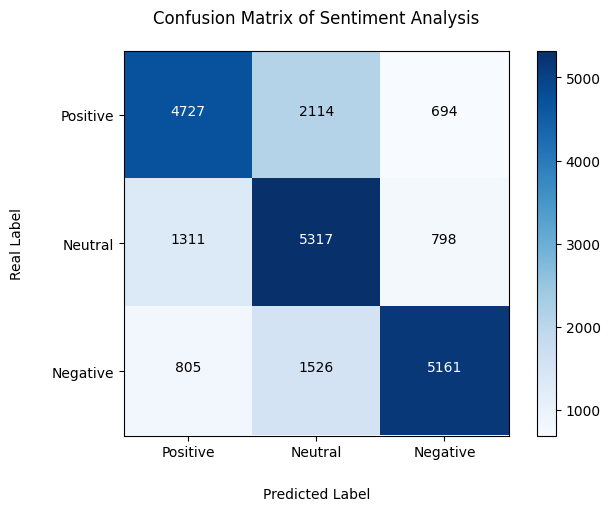

In [62]:
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")

*What we can gain from the Confusion Matrix above is that the model overall works well. It is able to categorize both positive and neutral sentiments correctly, while it seems to struggle a bit at determining negative sentiments. Of course, this is the effect of imbalanced data that we got from our original dataset, and luckily we can minimize the effect thanks to our SMOTE resampling before.*

Classification Scores

In [63]:
print(classification_report(y_test, Prediction))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66      7535
           1       0.59      0.72      0.65      7426
           2       0.78      0.69      0.73      7492

    accuracy                           0.68     22453
   macro avg       0.69      0.68      0.68     22453
weighted avg       0.69      0.68      0.68     22453



*Overall, to each of our sentiment categories, we got F1 Score of 68%, which is great and because of that we can conclude that our model works well on the dataset.*

# **Conclusion**

**Dataset**

1. Our dataset contains several features about user reviews on the Spotify app, but many, such as **Time_submitted** and **Reply**, are not directly relevant to sentiment analysis and may be excluded from the model.

2. **Total_thumbsup** could offer some insights but isn't strongly connected to sentiment, so it may also be omitted. Additionally, we may reconsider removing stopwords during preprocessing, as some common words could contain important sentiment cues.

3. Text analysis reveals that most reviews focus on specific Spotify features, suggesting that emphasizing these aspects in marketing could be beneficial for the app.








**Model**

1. We tested multiple classification models, and through 10-Fold Cross Validation, Logistic Regression provided the best accuracy, prompting us to focus on this model for further tuning.

2. After applying Logistic Regression on the test set, we achieved strong accuracy and high F1 Score, confirming its effectiveness for sentiment analysis.

3. To improve our model's generalization, we plan to experiment with Stratified K-Fold Cross Validation and consider scaling the data, although it is not strictly necessary.